In [35]:
import networkx as nx
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

In [36]:
%matplotlib notebook

Set the parameters

In [37]:
SAMPLE=1000                    # number of data extracted from every cluster
num_components = 3             # number of mixtures
mu_arr = [0,1.,5.]             # array with the centers

Draw the data

In [5]:
X = np.random.normal(loc=mu_arr[0], scale=1, size=SAMPLE) # args: scale=std
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))

Plot 

<IPython.core.display.Javascript object>


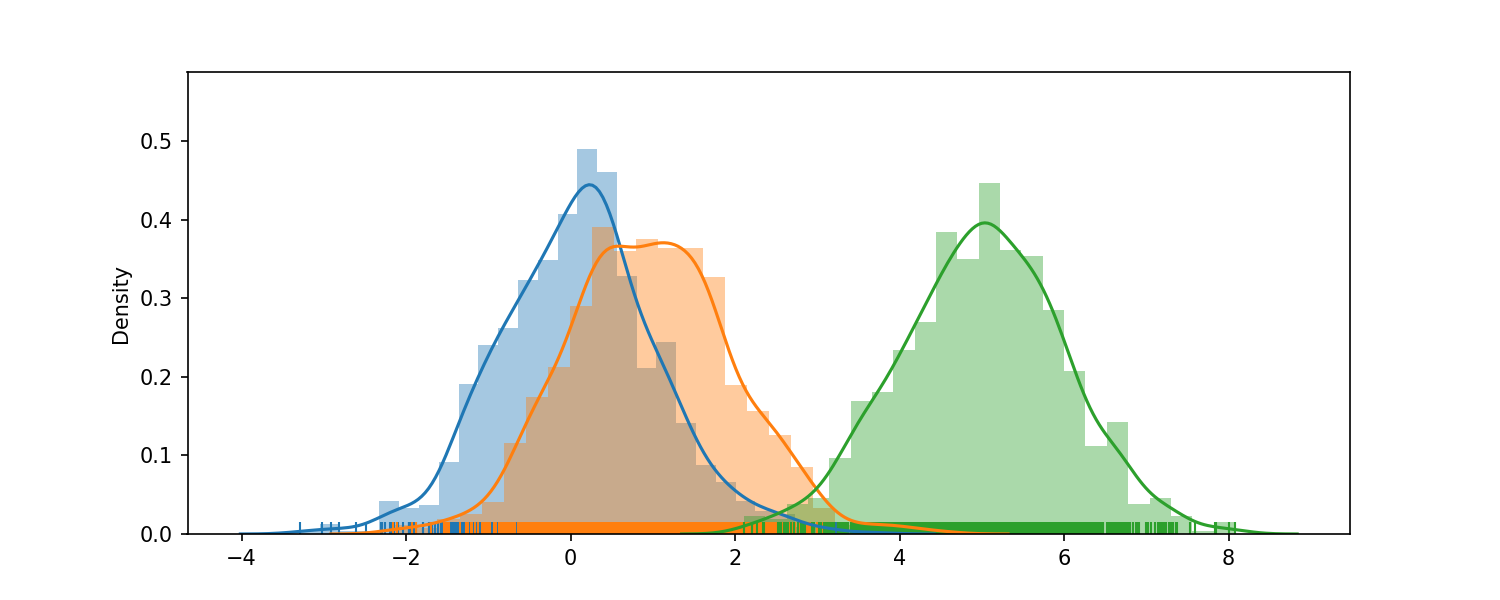

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, rug=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)
plt.savefig('figures/L12_GMMexample.pdf')

### Derive the equations for the ELBO.

In [7]:
# see tutorial solutions notes

### Implement CAVI updates for GMM

**Remark 1:** The support of the Dirichlet distribution is the set of $K$-dimensional vectors ${\displaystyle {\boldsymbol {x}}}$ whose entries are real numbers in the interval $(0,1)$ such that ${\displaystyle \|{\boldsymbol {x}}\|_{1}=1}$.

In [8]:
?np.add.outer

In [9]:
import numpy as np

class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X                 # data
        self.K = K                 # number of clusters
        self.N = self.X.shape[0]   # number of data
        self.sigma2 = sigma**2     # variance

    def _init(self):
        # parameter of categorical, sampled from dirichlet for each k
        # https://en.wikipedia.org/wiki/Dirichlet_distribution
        # Using Dir to sample rho s.t., sum(rho) = 1; this gives N K-tuples.
        self.rho = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N) 
        # Sampling random integers and then normalizing by the max; this gives K means
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        # all the terms that depend only on k
        t1 = 0.5*np.log(self.s2) - 0.5*(self.m**2+self.s2)/self.sigma2
        t1 = t1.sum()
        # unpack (x_i - m_k)^2...
        # here we use the outer sum, similar to the outer product, but summing the terms of two vectors
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2) # N*K (3000 x 3)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.rho)
        t2 *= self.rho
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))


    def _cavi(self):
        self._update_rho()
        self._update_mu()

    def _update_rho(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        # the second term is the same for every i
        exponent = t1 + t2[np.newaxis, :]
        self.rho = np.exp(exponent)
        # normalize so that sum over all the k is 1 -> sum over axis 1 (k) and generating vector with np.newaxis
        self.rho = self.rho / self.rho.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.rho*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.rho.sum(0))**(-1)
        assert self.m.size == self.K
        self.s2 = (1/self.sigma2 + self.rho.sum(0))**(-1)
        assert self.s2.size == self.K

### Fit the model to the data

In [10]:
ugmm = UGMM(X, 3)
ugmm.fit()

Init mean
[10.40860759  7.22716013  6.2124295 ]
Init s2
[0.71323199 0.6394516  0.59128083]
5 [0.56061434 4.96655148 0.44784831]
10 [0.58839796 4.96308804 0.41639709]
15 [0.631145   4.96448538 0.37548977]
20 [0.68614468 4.96713382 0.3239866 ]
25 [0.74530481 4.97111668 0.2701362 ]
30 [0.79522921 4.97548172 0.22614537]
35 [0.82819685 4.97892182 0.19797114]
40 [0.84626347 4.98101203 0.18287953]
45 [0.85510804 4.9820914  0.17559228]
50 [0.85919157 4.98260261 0.17225168]
55 [0.86102506 4.98283483 0.17075685]
60 [0.86183789 4.98293832 0.17009518]
65 [0.8621962  4.98298405 0.1698037 ]
70 [0.86235376 4.98300417 0.16967558]
75 [0.86242296 4.98301302 0.16961931]
80 [0.86245334 4.9830169  0.16959461]
85 [0.86246667 4.9830186  0.16958377]
90 [0.86247253 4.98301935 0.16957901]
95 [0.86247509 4.98301968 0.16957692]
ELBO converged with ll -148.034 at iteration 98


### Plot results at convergence

<IPython.core.display.Javascript object>


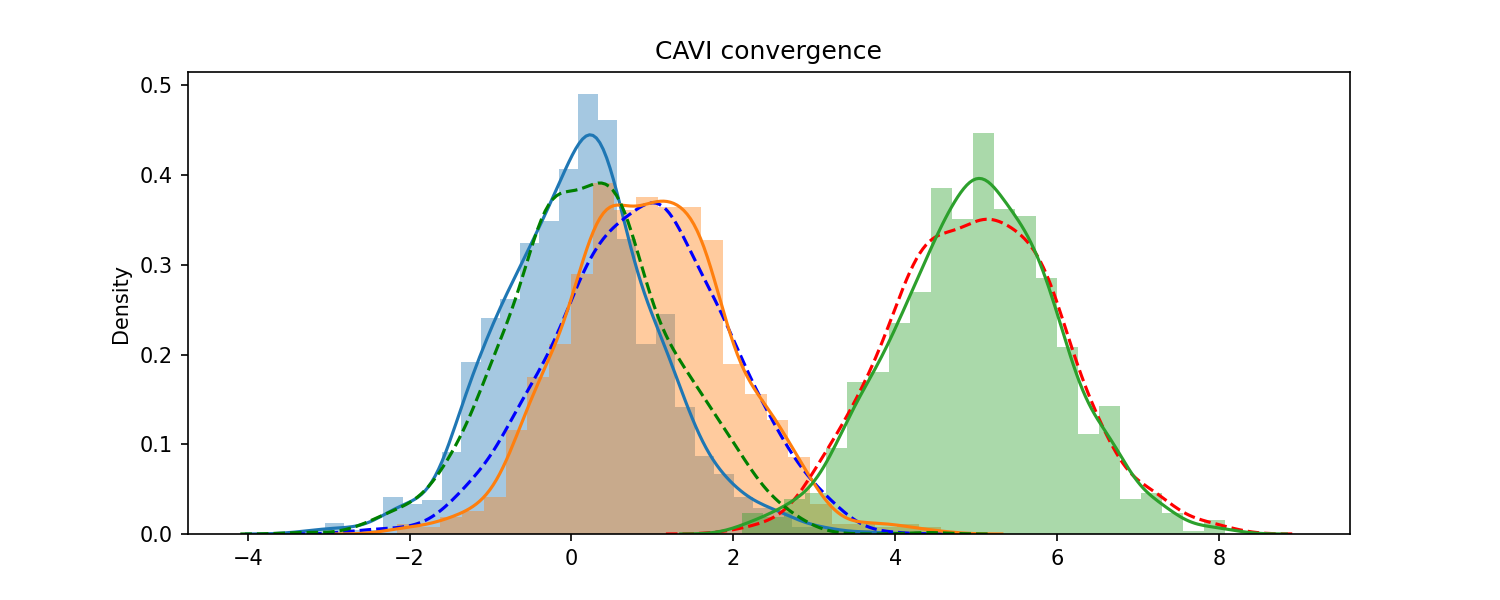

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title='CAVI convergence')
plt.savefig('figures/L12_GMMexample_itConv.pdf')

### Plot ELBO  
Detect changing points in the ELBO.

<IPython.core.display.Javascript object>


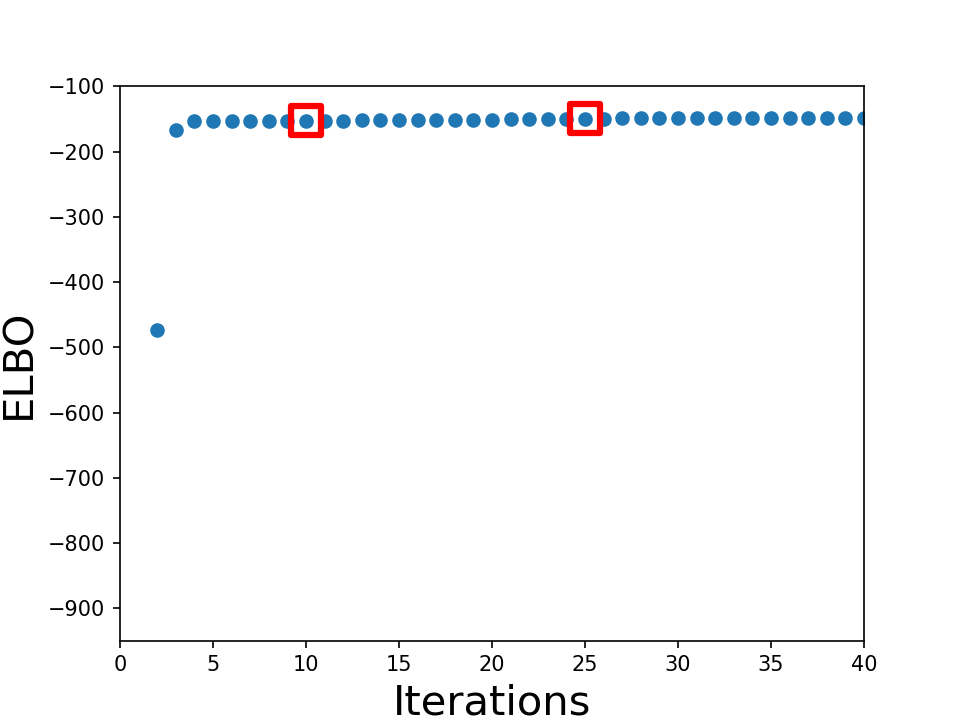

In [12]:
fs=20

it1=10
it2=25

plt.figure()
plt.scatter(np.arange(len(ugmm.elbo_values)),ugmm.elbo_values)
plt.scatter(it1,ugmm.elbo_values[it1],marker='s',facecolors='none',edgecolors='r',s=200, linewidth=3)
plt.scatter(it2,ugmm.elbo_values[it2],marker='s',facecolors='none',edgecolors='r',s=200, linewidth=3)
plt.xlim([0,40])
plt.ylim([-950,-100])
plt.xlabel('Iterations',fontsize=fs)
plt.ylabel('ELBO',fontsize=fs)
plt.savefig('figures/L12_GMMexample_ELBO.pdf')

### Plot result at the beginning and at the changing points.

<IPython.core.display.Javascript object>


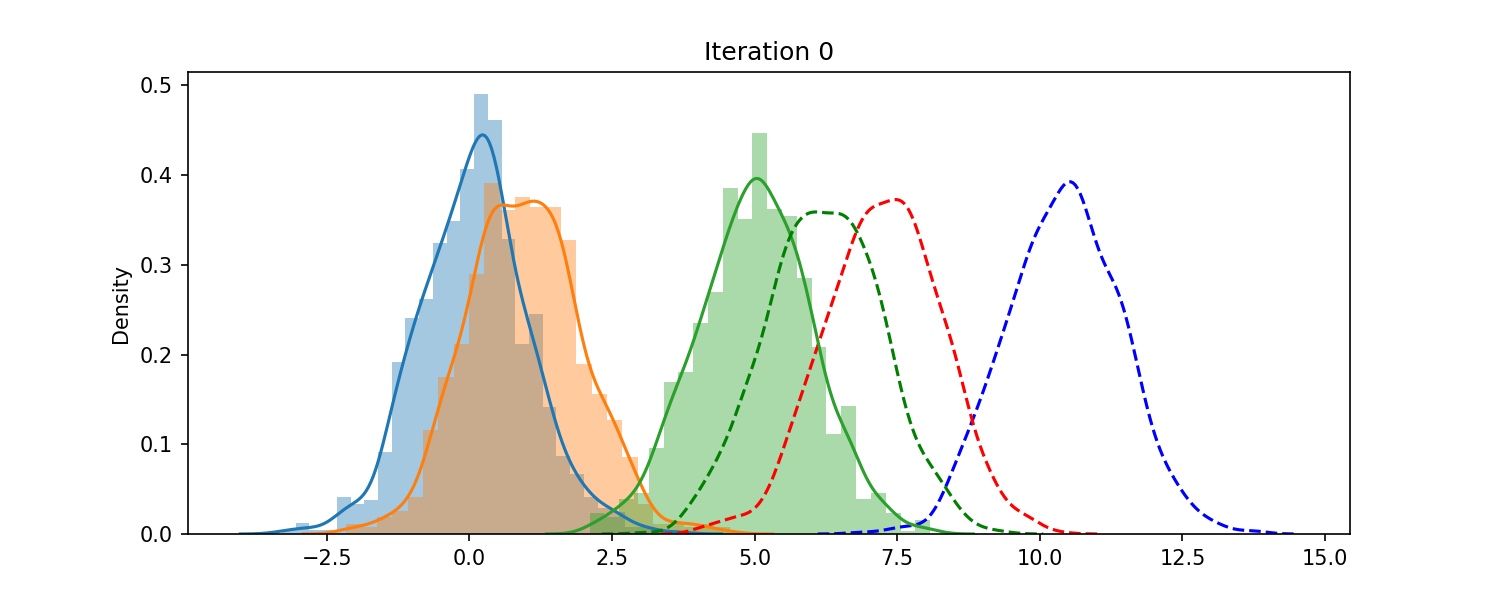

In [14]:
it=0
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title=f'Iteration {it}')
plt.savefig('figures/L12_GMMexample_it0.pdf')

<IPython.core.display.Javascript object>


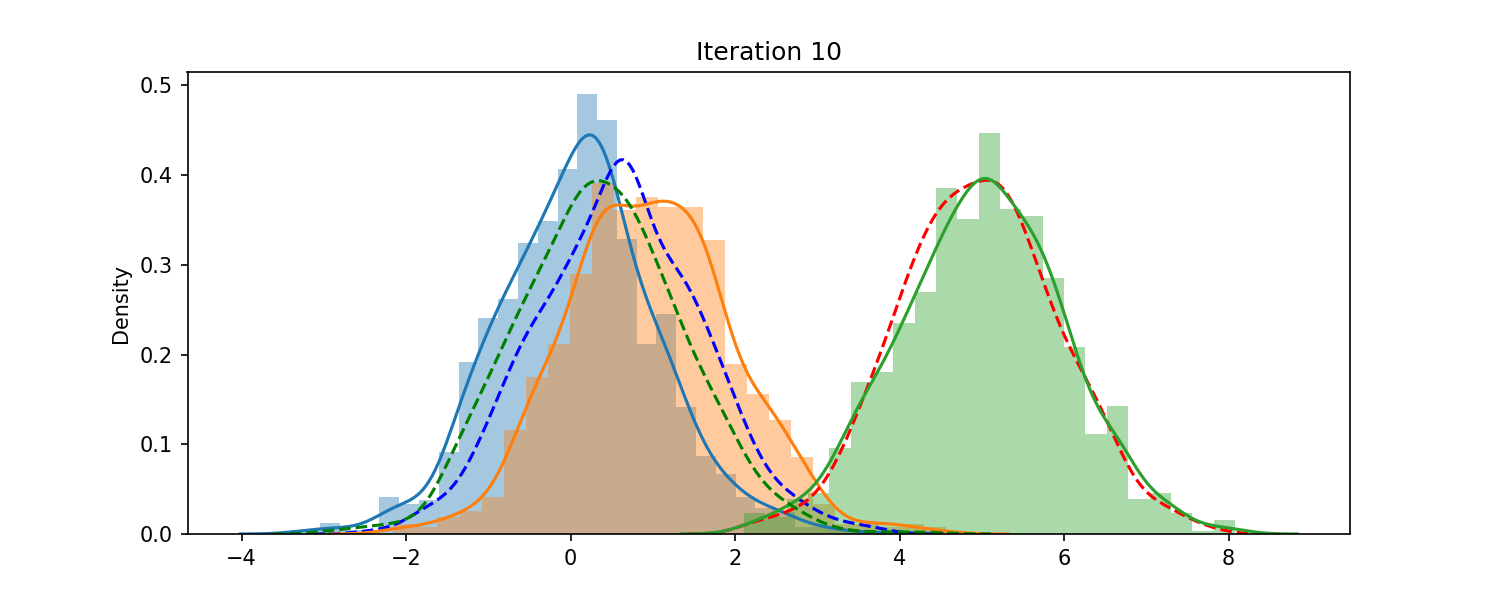

In [15]:
it=it1
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title=f'Iteration {it1}')
plt.savefig('figures/L12_GMMexample_it1.pdf')

<IPython.core.display.Javascript object>


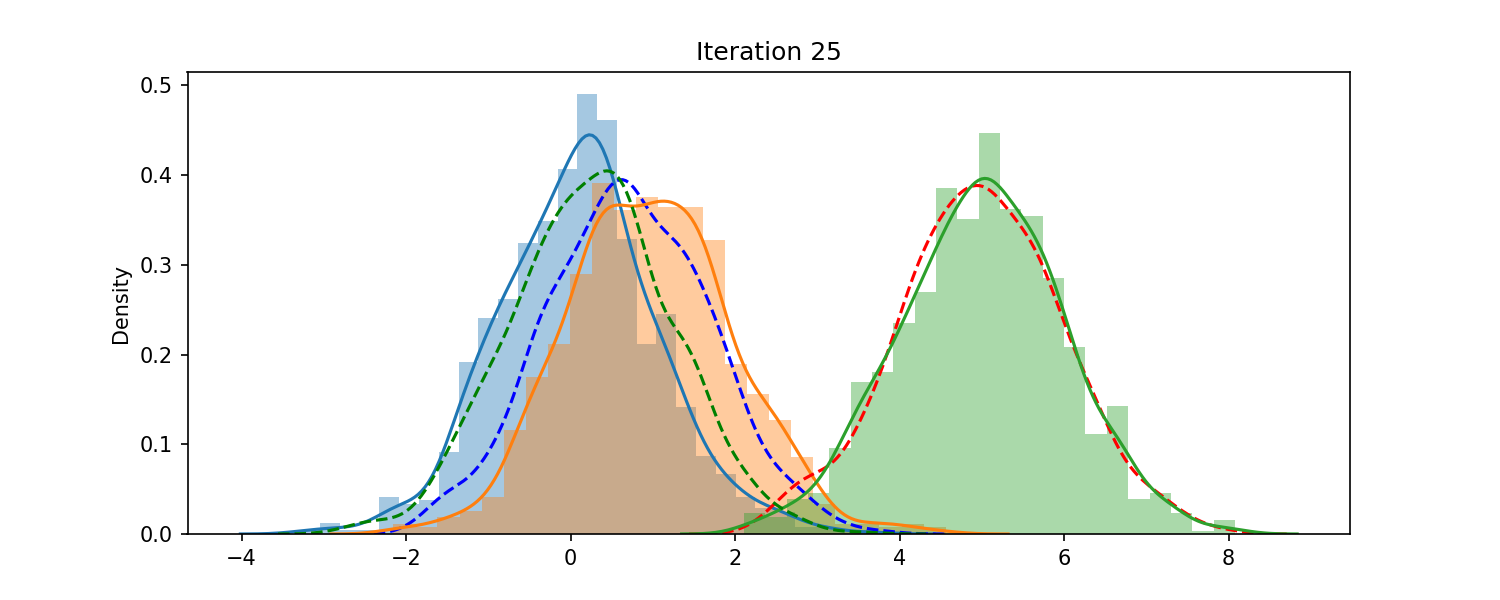

In [17]:
it=it2
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title=f'Iteration {it2}')
plt.savefig('figures/L12_GMMexample_it2.pdf')

### Accuracy

In [21]:
# greedily choose cluster correspondence to maximize accuracy
# map cluster number from variational approximation to ground truth
var_assignments = ugmm.rho.argmax(axis=1)

#for k in range(num_components):
#    chunk=var_assignments[k*SAMPLE:(k+1)*SAMPLE]
#    print(chunk)
    
# this piece of conde is important to solve the identifiability problem     
var_to_gt = dict()
for k in range(num_components):
    gt_k = max(
        set(range(num_components)).difference(set(var_to_gt.values())),
        key = lambda kk: (var_assignments[kk * SAMPLE : (kk + 1) * SAMPLE] == k).sum()
    )
    var_to_gt[k] = gt_k

In [22]:
var_assignments = np.vectorize(var_to_gt.get)(var_assignments)
acc = (var_assignments == np.repeat(range(num_components), SAMPLE)).sum() / X.shape[0]
print('Accuracy attained:', acc)

Accuracy attained: 0.769
